In [1]:
"""
Changes from OHE2:
-Here we do not drop features according to correlation with the target
-We also try here lambda = 1e-7
"""

'\nChanges from OHE2:\n-Here we do not drop features according to correlation with the target\n-We also try here lambda = 1e-7\n'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Data_cleaning import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

In [85]:
Y_tr = (y_train + 1) / 2

In [86]:
X_train, keep_mask = remove_nan_features(x_train, 0.4)
X_test = x_test[:, keep_mask]

In [87]:
print(X_train.shape, X_test.shape)

(328135, 163) (109379, 163)


In [88]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [89]:
print(np.sum(cat_mask), np.sum(num_mask))

102 61


In [90]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [91]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 163) (229695, 163) (229695,) (49220, 163) (49220,) (49220, 163) (49220,)


In [50]:
# Numerical imputation (compute medians from training)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
# Apply same medians to val/test
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)
# Categorical imputation (compute modes from training)
x_tr_imp, modes = impute_categorical(x_tr_imp, cat_mask)
# Apply same modes to val/test
x_va_imp, _ = impute_categorical(x_va_imp, cat_mask, modes)
x_te_imp, _ = impute_categorical(x_te_imp, cat_mask, modes)
x_test_imp, _ = impute_categorical(x_test_imp, cat_mask, modes)

In [51]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


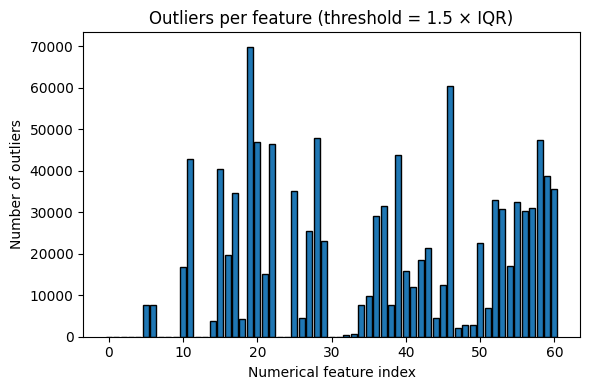

In [52]:
outlier_mask, outlier_counts = detect_outliers(x_tr_imp, num_mask, threshold=1.5, plot=True)

In [53]:
print(outlier_counts)

[    0     0     0     0     0  7523  7523     0     0     0 16765 42722
     0     0  3745 40468 19668 34545  4275 69823 46867 15215 46415     0
     0 35062  4608 25522 47979 23171     0     0   441   754  7544  9823
 29058 31441  7525 43748 15806 12023 18456 21474  4498 12403 60328  2105
  2772  2772 22622  6982 32876 30837 16957 32468 30401 30907 47415 38609
 35694]


In [54]:
outlier_pctg = outlier_counts / x_tr_imp.shape[0]
print(outlier_pctg)

[0.         0.         0.         0.         0.         0.03275213
 0.03275213 0.         0.         0.         0.07298809 0.18599447
 0.         0.         0.01630423 0.17618146 0.08562659 0.15039509
 0.01861164 0.30398137 0.20404014 0.06624001 0.20207231 0.
 0.         0.1526459  0.02006139 0.11111256 0.20888134 0.10087725
 0.         0.         0.00191994 0.00328261 0.03284355 0.04276541
 0.12650689 0.13688152 0.03276084 0.19046126 0.06881299 0.05234332
 0.08035003 0.09348919 0.01958249 0.05399769 0.26264394 0.00916433
 0.01206818 0.01206818 0.09848712 0.03039683 0.14312893 0.13425194
 0.07382398 0.14135266 0.13235377 0.13455669 0.20642591 0.16808812
 0.15539737]


In [55]:
drop_threshold = 0.1
new_num_mask = outlier_pctg < drop_threshold


In [56]:
#Change the mask again
keep_mask = np.ones(x_tr_imp.shape[1], dtype=bool)
num_indices = np.where(num_mask)[0]
keep_mask[num_indices] = new_num_mask

In [57]:
x_tr_filt = x_tr_imp[:, keep_mask]
x_va_filt = x_va_imp[:, keep_mask]
x_te_filt = x_te_imp[:, keep_mask]
x_test_filt = x_test_imp[:, keep_mask]
num_mask = num_mask[keep_mask]
cat_mask = cat_mask[keep_mask]

In [58]:
print(np.sum(num_mask), np.sum(cat_mask))

39 102


In [59]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_filt, cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_filt, cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_filt, cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_filt, cat_mask, categories, drop_first=True)

In [60]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 369) (49220, 369) (49220, 369) (109379, 369)


In [61]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [62]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

330 39


In [63]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [64]:
x_tr_std, means, stds = standardize_features(x_tr_enc, num_mask_enc)
x_va_std, _, _ = standardize_features(x_va_enc, num_mask_enc, means, stds)
x_te_std, _, _ = standardize_features(x_te_enc, num_mask_enc, means, stds)
x_test_std, _, _ = standardize_features(x_test_enc, num_mask_enc, means, stds)

In [65]:
corr_y = feature_target_correlation(x_tr_std, y_tr)


In [66]:

min_corr = 0.04
keep_mask_corr = np.abs(corr_y) > min_corr


In [67]:
x_tr_sel = x_tr_std[:, keep_mask_corr]
x_va_sel = x_va_std[:, keep_mask_corr]
x_te_sel = x_te_std[:, keep_mask_corr]
x_test_sel = x_test_std[:, keep_mask_corr]

In [68]:
print(x_tr_sel.shape, x_va_sel.shape, x_te_sel.shape, x_test_sel.shape)

(229695, 111) (49220, 111) (49220, 111) (109379, 111)


In [69]:
cat_mask_sel, num_mask_sel = detect_categorical_features(x_tr_sel, max_unique=10)

In [70]:
print(np.sum(cat_mask_sel))

99


In [71]:
corr_mat = correlation_matrix(x_tr_sel)


In [72]:
threshold = 0.8
to_drop = set()

for i in range(corr_mat.shape[0]):
    for j in range(i + 1, corr_mat.shape[1]):
        if abs(corr_mat[i, j]) > threshold:
            # Compare absolute correlation with y
            if abs(corr_y[i]) < abs(corr_y[j]):
                to_drop.add(i)
            else:
                to_drop.add(j)

keep_mask_inter = np.ones(x_tr_sel.shape[1], dtype=bool)
keep_mask_inter[list(to_drop)] = False



In [73]:
x_tr_final = x_tr_sel[:, keep_mask_inter]
x_va_final = x_va_sel[:, keep_mask_inter]
x_te_final = x_te_sel[:, keep_mask_inter]
x_test_final = x_test_sel[:, keep_mask_inter]

In [35]:
print("Dropped (low corr):", np.sum(~keep_mask_corr))
print("Dropped (high inter):", np.sum(~keep_mask_inter))
print("Remaining features:", x_tr_final.shape[1])


Dropped (low corr): 252
Dropped (high inter): 26
Remaining features: 81


In [36]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_final,
    y_va, x_va_final,
    pos_weights=[9, 9.5, 10],
    lambdas=[1e-8],
    thresholds=np.linspace(0.65, 0.85, 200),
    max_iter=10000,
    gamma=0.5
)



=== Run 1/3 (pos_weight=9, lambda_=1e-08) ===
New best F1 = 0.4110
New best F1 = 0.4117
New best F1 = 0.4122
New best F1 = 0.4122
New best F1 = 0.4127
New best F1 = 0.4129
New best F1 = 0.4135
New best F1 = 0.4138
New best F1 = 0.4147
New best F1 = 0.4148
New best F1 = 0.4149
New best F1 = 0.4150
New best F1 = 0.4153
New best F1 = 0.4153
New best F1 = 0.4153
New best F1 = 0.4156
New best F1 = 0.4158
New best F1 = 0.4165
New best F1 = 0.4167
New best F1 = 0.4169

=== Run 2/3 (pos_weight=9.5, lambda_=1e-08) ===

=== Run 3/3 (pos_weight=10, lambda_=1e-08) ===

=== Grid Search Complete ===
Best F1 = 0.4169 at pos_weight=9, λ=1e-08, threshold=0.6902010050251256


In [37]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [38]:
best_lambda = 1e-8
best_pos_weight = 9.0
best_neg_weight = 1.0
best_threshold = 0.6902010050251256

final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=10000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.4522
Iter   100 | Loss = 0.481075 | GradNorm = 0.0133
Iter   200 | Loss = 0.476331 | GradNorm = 0.0072
Iter   300 | Loss = 0.474537 | GradNorm = 0.0050
Iter   400 | Loss = 0.473548 | GradNorm = 0.0040
Iter   500 | Loss = 0.472888 | GradNorm = 0.0033
Iter   600 | Loss = 0.472396 | GradNorm = 0.0029
Iter   700 | Loss = 0.472005 | GradNorm = 0.0027
Iter   800 | Loss = 0.471682 | GradNorm = 0.0024
Iter   900 | Loss = 0.471409 | GradNorm = 0.0022
Iter  1000 | Loss = 0.471176 | GradNorm = 0.0021
Iter  1100 | Loss = 0.470974 | GradNorm = 0.0019
Iter  1200 | Loss = 0.470799 | GradNorm = 0.0018
Iter  1300 | Loss = 0.470646 | GradNorm = 0.0017
Iter  1400 | Loss = 0.470511 | GradNorm = 0.0016
Iter  1500 | Loss = 0.470393 | GradNorm = 0.0015
Iter  1600 | Loss = 0.470288 | GradNorm = 0.0014
Iter  1700 | Loss = 0.470196 | GradNorm = 0.0013
Iter  1800 | Loss = 0.470114 | GradNorm = 0.0012
Iter  1900 | Loss = 0.470041 | GradNorm = 0.0012
Iter  2000 | Loss = 

In [39]:
print(w_final @ w_final)

16.412879234342274


In [40]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 87.01%
 F1 Score: 0.4252


Confusion Matrix:
[[40460  4414]
 [ 1981  2365]]
TN=40460, FP=4414, FN=1981, TP=2365


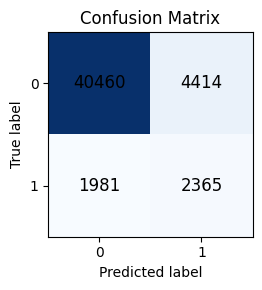

In [41]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)

In [42]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "ModelOHE32_preds.csv")